In [7]:
from pathlib import Path
import os, json

CONFIG = "dataset_config.json"

def save_config(root):
    with open(CONFIG, "w") as f:
        json.dump({"dataset_root": str(root)}, f)

def repo_root():
    cwd = Path.cwd().resolve()
    if (cwd / "data").exists():
        return cwd
    if cwd.name == "main_code" and (cwd.parent / "data").exists():
        return cwd.parent.resolve()
    return cwd

def find_jpeg_dir(root):
    root = Path(root)
    for r, dirs, _ in os.walk(root):
        if "JPEGImages" in dirs:
            return Path(r) / "JPEGImages"
    return None

def ensure_dataset():
    base = repo_root() / "data" / "processed"
    candidates = [
        base / "PASCAL_VOC" / "PASCAL_VOC",
        base / "PASCAL_VOC",
        base
    ]
    json_names = {"pascal_train2007.json", "pascal_val2007.json", "pascal_test2007.json"}
    for target in candidates:
        if target.is_dir():
            json_ok = all((target / j).exists() for j in json_names)
            if json_ok or find_jpeg_dir(target):
                save_config(target)
                print("Using dataset under:", target)
                return target
    raise RuntimeError("Dataset not found. Expected under one of: " + ", ".join(str(c) for c in candidates))

dataset_root = Path(ensure_dataset())

Using dataset under: C:\Users\giaco\Desktop\Projects\V&C\PASCAL_VOC_2007\data\processed\PASCAL_VOC\PASCAL_VOC


In [15]:
# percorsi relativi: usiamo i JSON in data/processed/PASCAL_VOC/PASCAL_VOC (train/val/test)
import os
import json
from pathlib import Path

json_dir = dataset_root
json_dir_str = str(json_dir)
processed_root = json_dir.parent.parent  # saliamo a data/processed per trovare VOCtrainval/VOCtest
train_json = json_dir / "pascal_train2007.json"
val_json = json_dir / "pascal_val2007.json"
test_json = json_dir / "pascal_test2007.json"

trainval_jpeg_dir = processed_root / "VOCtrainval_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"
test_jpeg_dir = processed_root / "VOCtest_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"

with open(train_json, "r") as f:
    data = json.load(f)

def candidate_image_paths(fname):
    # usiamo direttamente i percorsi dichiarati, senza ricerca ricorsiva
    return [
        trainval_jpeg_dir / fname,
        test_jpeg_dir / fname,
    ]

# ispezioniamo il contenuto
print("Keys in the JSON file:", data.keys())
# ci sono le chiavi: images, type, annotations, categories

# ispezioniamo le prime 5 immagini
print("First 5 images:", data['images'][:5])
# ispezioniamo le prime 5 annotazioni
print("First 5 annotations:", data['annotations'][:5])
# ispezioniamo le categorie
print("Categories:", data['categories'])
# ispezioniamo il tipo di dataset
print("Type of dataset:", data['type'])

# visualizziamo 3 immagini e basta
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_image(image_id):
    image_info = next(img for img in data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Immagine {fname} non trovata. Percorsi provati: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == ann['category_id'])
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

Keys in the JSON file: dict_keys(['images', 'type', 'annotations', 'categories'])
First 5 images: [{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
First 5 annotations: [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[

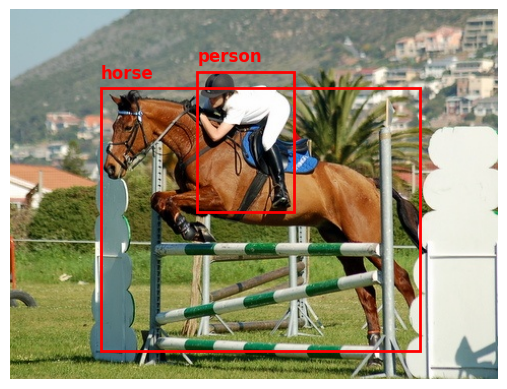

In [16]:
visualize_image(17)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as T


# Define the transform_image_and_boxes function
def transform_image_and_boxes(image, annotations):
    import torchvision.transforms as T
    transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
    transformed_image = transform(image)
    original_width, original_height = image.size
    scale_x = 224 / original_width
    scale_y = 224 / original_height
    transformed_annotations = []
    for ann in annotations:
        bbox = ann['bbox']
        scaled_bbox = [bbox[0] * scale_x, bbox[1] * scale_y, bbox[2] * scale_x, bbox[3] * scale_y]
        transformed_annotations.append({
            'bbox': scaled_bbox,
            'category_id': ann['category_id']
        })
    return transformed_image, transformed_annotations


class PascalVOCDataset(Dataset):
    def __init__(self, data, root, transform=None):
        self.data = data
        self.root = root
        self.transform = transform
        self.images = self.data['images']
        self.num_classes = len(self.data['categories'])
        self.catid_to_idx = {cat['id']: (cat['id'] - 1) for cat in self.data['categories']}
        self.image_to_labels = {}
        for ann in self.data['annotations']:
            img_id = ann['image_id']
            cid = ann['category_id']
            self.image_to_labels.setdefault(img_id, set()).add(self.catid_to_idx[cid])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_id = image_info['id']
        fname = image_info['file_name']

        candidates = [
            os.path.join(self.root, fname),
            os.path.join(self.root, 'JPEGImages', fname),
            os.path.join(self.root, 'VOC2007', 'JPEGImages', fname),
            os.path.join(self.root, 'images', fname),
            os.path.join(os.path.dirname(path), fname)
        ]

        image_path = None
        for c in candidates:
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            for root, _, files in os.walk(self.root):
                if fname in files:
                    image_path = os.path.join(root, fname)
                    break

        if image_path is None:
            raise FileNotFoundError(f"Image {fname} not found under {self.root}")

        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        labels = torch.zeros(self.num_classes, dtype=torch.float32)
        for cls_idx in self.image_to_labels.get(image_id, set()):
            labels[cls_idx] = 1.0

        return image, labels

In [ ]:
# Initialize the dataloader (multi-label per immagine)
import torchvision.transforms as T

# Transform condivisa: resize, tensor, normalizzazione (ImageNet)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32
shuffle = True
train_dataset = PascalVOCDataset(data, dataset_root, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Initialize the model
import torch.nn as nn
import torch.nn.functional as F
import torch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(data['categories'])
model = SimpleCNN(num_classes)

# Initialize the optimizer e loss per multi-label
import torch.optim as optim
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
import os
import torch
from tqdm.notebook import tqdm

model_path = "simple_cnn_pascalvoc_multilabel.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print("Modello multilabel caricato dal file salvato.")
else:
    print("Nessun modello salvato trovato. Avvio del training multilabel...")

# training loop multilabel
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(dataloader)
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        optimizer.zero_grad()
        outputs = model(images)  # logits shape [B, C]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (batch_idx+1) % 10 == 0 or (batch_idx+1) == total_batches:
            pct = 100*(batch_idx+1)/total_batches
            tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx+1}/{total_batches} ({pct:.1f}%) - Loss batch: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total_batches:.4f}")

# save the trained model
torch.save(model.state_dict(), model_path)
print("Modello salvato:", model_path)


In [ ]:
# Valutazione multi-label sul set di test
import json
import torch

eval = r"C:\\Users\\sebaw\\.cache\\kagglehub\\datasets\\zaraks\\pascal-voc-2007\\versions\\1\\PASCAL_VOC\\PASCAL_VOC\\pascal_test2007.json"
with open(eval, 'r') as f:
    eval_data = json.load(f)

eval_dataset = PascalVOCDataset(eval_data, dataset_root, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

model.eval()
threshold = 0.5
TP = FP = FN = 0
exact_match = 0
n_samples = 0

with torch.no_grad():
    for images, labels in eval_dataloader:
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

        # micro TP/FP/FN
        TP += ((preds == 1) & (labels == 1)).sum().item()
        FP += ((preds == 1) & (labels == 0)).sum().item()
        FN += ((preds == 0) & (labels == 1)).sum().item()

        # exact match ratio
        exact_match += (preds.eq(labels).all(dim=1)).sum().item()
        n_samples += labels.size(0)

precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
micro_f1 = 2 * precision * recall / (precision + recall + 1e-8)
exact_match_ratio = exact_match / max(n_samples, 1)

print(f"Micro-Precision: {precision:.4f}")
print(f"Micro-Recall:    {recall:.4f}")
print(f"Micro-F1:        {micro_f1:.4f}")
print(f"Exact match:     {exact_match_ratio*100:.2f}%")

In [ ]:
# Visualizza immagine e vettore di probabilità ordinate per classe
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import os
import random
from PIL import Image

# class names ordinati per indice [0..C-1]
num_classes = len(data['categories'])
class_names = [None] * num_classes
for cat in data['categories']:
    class_names[cat['id'] - 1] = cat['name']

def _find_image_path(fname, base_root, json_dir):
    candidates = [
        os.path.join(base_root, fname),
        os.path.join(base_root, 'JPEGImages', fname),
        os.path.join(base_root, 'VOC2007', 'JPEGImages', fname),
        os.path.join(base_root, 'images', fname),
        os.path.join(json_dir, fname)
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    # fallback: ricerca ricorsiva
    for r, _, files in os.walk(base_root):
        if fname in files:
            return os.path.join(r, fname)
    return None

def visualize_image_and_probs(image_id=None, use_eval=True, top_k=20):
    """
    Mostra immagine e lista ordinata (desc) delle probabilità per classe.
    - image_id: se None, sceglie un’immagine casuale dal dataset selezionato.
    - use_eval: True usa eval_data, False usa data.
    - top_k: quante classi mostrare (su C totali).
    """
    ds = eval_data if use_eval else data
    imgs = ds['images']
    anns = ds['annotations']

    if image_id is None:
        image_id = random.choice(imgs)['id']

    image_info = next(img for img in imgs if img['id'] == image_id)
    fname = image_info['file_name']
    json_dir = os.path.dirname(eval) if use_eval else os.path.dirname(path)
    image_path = _find_image_path(fname, dataset_root, json_dir)
    if image_path is None:
        raise FileNotFoundError(f"Immagine {fname} non trovata sotto {dataset_root}")

    # input per il modello (normalizzato)
    pil_img = Image.open(image_path).convert('RGB')
    inp = transform(pil_img).unsqueeze(0)  # [1,3,224,224]

    # forward -> probabilità
    model.eval()
    with torch.no_grad():
        logits = model(inp)
        probs = torch.sigmoid(logits).squeeze(0)  # [C]

    # ordina per probabilità desc
    vals, idxs = torch.sort(probs, descending=True)
    top_k = min(top_k, probs.numel())
    vals = vals[:top_k].cpu().numpy()
    idxs = idxs[:top_k].cpu().numpy()

    # GT: classi presenti nell'immagine (multi-label)
    present = set()
    for ann in anns:
        if ann['image_id'] == image_id:
            present.add(ann['category_id'] - 1)

    # Visualizzazione
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # a sinistra: immagine (non normalizzata)
    axes[0].imshow(pil_img)
    axes[0].set_title(f"Image ID: {image_id}")
    axes[0].axis('off')

    # a destra: classi ordinate con probabilità; segna quelle GT
    axes[1].axis('off')
    lines = []
    for rank, (i, p) in enumerate(zip(idxs, vals), start=1):
        name = class_names[i] if 0 <= i < len(class_names) else f"cls_{i}"
        mark = " (GT)" if i in present else ""
        lines.append(f"{rank:2d}. {name:12s}  p={p:0.3f}{mark}")
    text = "\n".join(lines)
    axes[1].text(0, 1, text, fontsize=12, family='monospace', va='top')
    axes[1].set_title("Probabilità per classe (desc)")
    plt.tight_layout()
    plt.show()


visualize_image_and_probs()                 # immagine casuale dal set di valutazione
# visualize_image_and_probs(image_id=12)      # immagine specifica (test)
# visualize_image_and_probs(use_eval=False)   # dal set di training
# visualize_image_and_probs(top_k=15)         # mostra le top-15 classi